In [30]:
%config Completer.use_jedi = False

import sys
sys.path.insert(1,'../')
sys.path.insert(1,'../models/')


# Pytorch related
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data as dt
from torchinfo import summary
import torchvision.models as pretrained_models
from alexnet_pytorch import AlexNet
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils import model_zoo
from IPython.html.widgets import interact, interactive, fixed


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import numpy as np
import pandas as pd
import os
import glob
import json



# Extra imports
from lib.feature_extractor import FeatureExtractor
from lib.custom_dataset import Contour_Dataset
from lib.build_fe_ft_models import *
from lib.misc_functions import *
from lib.field_stim_functions import *

In [2]:
device = torch.device('cuda:'+'3')

# Helper functions

In [3]:
def get_train_val_acc(files):
    all_models_train_acc={}
    all_models_val_acc={}

    for f in files:
        checkpoint=torch.load(f)
        all_models_train_acc[checkpoint['training_config']['layer_name']]=checkpoint['metrics']['train_acc'][-1]
        all_models_val_acc[checkpoint['training_config']['layer_name']]=checkpoint['metrics']['val_acc'][-1]



    myKeys = list(all_models_train_acc.keys())
    myKeys.sort()
    all_models_train_acc = {i: all_models_train_acc[i] for i in myKeys}



    myKeys = list(all_models_val_acc.keys())
    myKeys.sort()
    all_models_val_acc = {i: all_models_val_acc[i] for i in myKeys}
    
    
    return all_models_train_acc,all_models_val_acc

In [4]:
def get_list_acc(acc_dict,list_layers):
    acc=[]
    for i in range(len(list_layers)):
        # layer=list_layers[i].replace('_','.')
        layer=list_layers[i]
        if layer in acc_dict.keys():
            acc.append(acc_dict[layer])
            
    return acc


# 1. Training and Validation Accuracy (& Loss)

### Load the model

In [5]:
## Sup regular 
# checkpoint=torch.load('../../dev/model_hub/regular_alexnet/model_sup-regular_layer_avgpool_mode_finetune.pt')
# checkpoint=torch.load('../../dev/model_hub/regular_alexnet/model_sup-regular_layer_avgpool_mode_frozen.pt')



## Sup regular - Constrained finetuning
# checkpoint=torch.load('../../dev/model_hub/constrained_finetuning/alexnet/B_018/model_sup-regular_layer_avgpool_mode_finetune.pt')


## Resnet50 and Bagnet (9*9 and 33*33)
# checkpoint=torch.load('../../dev/model_hub//bagnet_resnet/model_sup-resnet50_layer_avgpool_mode_finetune.pt')
# checkpoint=torch.load('../../dev/model_hub/bagnet_resnet/model_sup-bagnet_layer_layer4_mode_finetune.pt')
# checkpoint=torch.load('../../dev/model_hub/bagnet_resnet/model_sup-bagnet33_layer_layer4_mode_finetune.pt')


## Sup stylized
# checkpoint=torch.load('../../dev/model_hub/stylized_alexnet/model_sup-stylized_layer_avgpool_mode_finetune.pt')
# checkpoint=torch.load('../../dev/model_hub/stylized_alexnet/model_sup-stylized_layer_avgpool_mode_frozen.pt')


## Unsupervised
# checkpoint=torch.load('../../dev/model_hub/unsupervised_alexnet/model_unsup-barlow_layer_backbone_mode_finetune.pt')
# checkpoint=torch.load('../../dev/model_hub/unsupervised_alexnet/model_unsup-barlow_layer_backbone_mode_frozen.pt')

## Vision Transformer
# checkpoint=torch.load('../../dev/model_hub/vision_transformer/model_vit-regular_layer_transformer-blocks-0-attn_mode_frozen.pt')





In [6]:
## Custom model


checkpoint=torch.load('../../dev/new_ccn23/varying_ITM_largeRF/model_alexnet-styim-categ_layer_avgpool_mode_finetune_beta_020.pt')




In [7]:
checkpoint['visual_diet_config']

{'root_directory': '/home/jovyan/work/Datasets/contour_integration/model-training/config_0/',
 'get_B': [20],
 'get_D': [32],
 'get_A': [0],
 'get_numElements': [12]}

In [8]:
checkpoint['metrics']['val_acc'][-1]

0.96

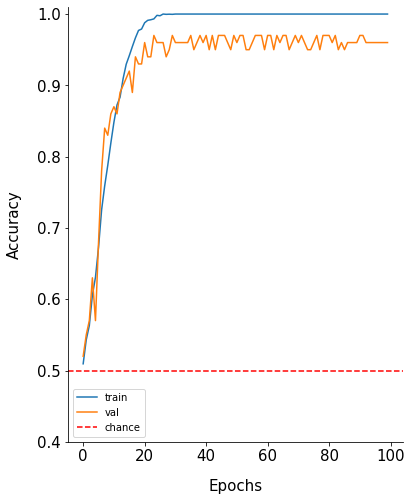

In [9]:
plt.figure(figsize=(6,8))
plt.plot(np.arange(len(checkpoint['metrics']['train_acc'])),checkpoint['metrics']['train_acc'],label='train')
plt.plot(np.arange(len(checkpoint['metrics']['val_acc'])),checkpoint['metrics']['val_acc'],label='val')
plt.axhline(y=0.5,linestyle='--',color='r',label='chance')

plt.xlabel('Epochs',fontsize=15,labelpad=15)
plt.ylabel('Accuracy',fontsize=15,labelpad=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)   
plt.ylim(0.4,1.01)

    
plt.legend()

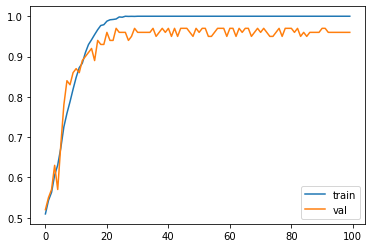

In [10]:
plt.plot(np.arange(len(checkpoint['metrics']['train_acc'])),checkpoint['metrics']['train_acc'],label='train')
plt.plot(np.arange(len(checkpoint['metrics']['val_acc'])),checkpoint['metrics']['val_acc'],label='val')    
plt.legend()

In [11]:
loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)

loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)

_IncompatibleKeys(missing_keys=['base_model.classifier.1.weight', 'base_model.classifier.1.bias', 'base_model.classifier.4.weight', 'base_model.classifier.4.bias', 'base_model.classifier.6.weight', 'base_model.classifier.6.bias'], unexpected_keys=[])

# 2. Comparing alexnet avgpool finetune broad with and without AF

In [12]:

alexnet_without_af=torch.load('../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt')['metrics']['val_acc']
alexnet_with_af=torch.load('../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad_af/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt')['metrics']['val_acc']


In [ ]:
plt.figure(figsize=(15,12))



plt.plot(np.arange(len(alexnet_without_af)),alexnet_without_af,linewidth=3.0,label='alexnet_without_af')
plt.plot(np.arange(len(alexnet_with_af)),alexnet_with_af,linewidth=3.0,label='alexnet_with_af')






plt.axhline(y=0.5,linestyle='--',color='r',label='chance',alpha=0.1)

plt.xlabel('Epochs',fontsize=15,labelpad=15)
plt.ylabel('Validation Accuracy',fontsize=15,labelpad=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)   
plt.ylim(0.4,1.01)

    
plt.legend(fontsize=12,frameon=False)

plt.show()

# 3. Comparing alexnet bagnet validation accuracies

In [125]:
# alexnet_100=torch.load('../../dev/old/model_hub/bagnet_alexnet/model_alexnet-epoch-100_layer_avgpool_mode_finetune.pt')['metrics']['val_acc']
# alexnet_50=torch.load('../../dev/old/model_hub/bagnet_alexnet/model_alexnet-epoch-050_layer_avgpool_mode_finetune.pt')['metrics']['val_acc']
# alexnet_60=torch.load('../../dev/old/model_hub/bagnet_alexnet/model_alexnet-epoch-060_layer_avgpool_mode_finetune.pt')['metrics']['val_acc']

# alexnet33=torch.load('../../dev/old/model_hub/bagnet_alexnet/model_alexnet-bagnet33_layer_features-9_mode_finetune.pt')['metrics']['val_acc']
# alexnet31=torch.load('../../dev/old/model_hub/bagnet_alexnet/model_alexnet-bagnet31_layer_features-9_mode_finetune.pt')['metrics']['val_acc']
# alexnet17=torch.load('../../dev/old/model_hub/bagnet_alexnet/model_alexnet-bagnet17_layer_features-9_mode_finetune.pt')['metrics']['val_acc']
# alexnet11=torch.load('../../dev/old/model_hub/bagnet_alexnet/model_alexnet-bagnet11_layer_features-9_mode_finetune.pt')['metrics']['val_acc']

In [126]:
alexnetbase=torch.load('../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_features-12_mode_finetune.pt')['metrics']['val_acc']

alexnetepoch50=torch.load('../../dev/new_ccn23/alexnet-epoch50_regimagenet_categ_finetune_broad/model_alexnet-epoch50-regim-categ_layer_features-12_mode_finetune.pt')['metrics']['val_acc']
alexnetepoch100=torch.load('../../dev/new_ccn23/alexnet-epoch100_regimagenet_categ_finetune_broad/model_alexnet-epoch100-regim-categ_layer_features-12_mode_finetune.pt')['metrics']['val_acc']

alexnet33=torch.load('../../dev/new_ccn23/alexnet-bagnet33_regimagenet_categ_finetune_broad/model_alexnet-bagnet33-regim-categ_layer_features-9_mode_finetune.pt')['metrics']['val_acc']
alexnet31=torch.load('../../dev/new_ccn23/alexnet-bagnet31_regimagenet_categ_finetune_broad/model_alexnet-bagnet31-regim-categ_layer_features-9_mode_finetune.pt')['metrics']['val_acc']

alexnet17=torch.load('../../dev/new_ccn23/alexnet-bagnet17_regimagenet_categ_finetune_broad/model_alexnet-bagnet17-regim-categ_layer_features-9_mode_finetune.pt')['metrics']['val_acc']
alexnet11=torch.load('../../dev/new_ccn23/alexnet-bagnet11_regimagenet_categ_finetune_broad/model_alexnet-bagnet11-regim-categ_layer_features-9_mode_finetune.pt')['metrics']['val_acc']



In [127]:
print(alexnetbase[-1])
print(alexnetepoch50[-1])
print(alexnetepoch100[-1])


print(alexnet33[-1])
print(alexnet31[-1])
print(alexnet17[-1])
print(alexnet11[-1])

0.8883333333333334
0.8933333333333334
0.9033333333333334
0.7066666666666667
0.6183333333333334
0.5700000000000001
0.5233333333333333


In [128]:
custom_colors = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a']

In [129]:
color_shades_barplot=[(0.8229757785467128, 0.8898269896193771, 0.9527566320645905),
                      (0.6965013456362937, 0.8248366013071895, 0.9092656670511342),
                      (0.5168627450980392, 0.7357477893118032, 0.8601922337562476),
                      (0.3363783160322953, 0.6255132641291811, 0.8067358708189158),
                      (0.8275, 0.8275, 0.8275)]

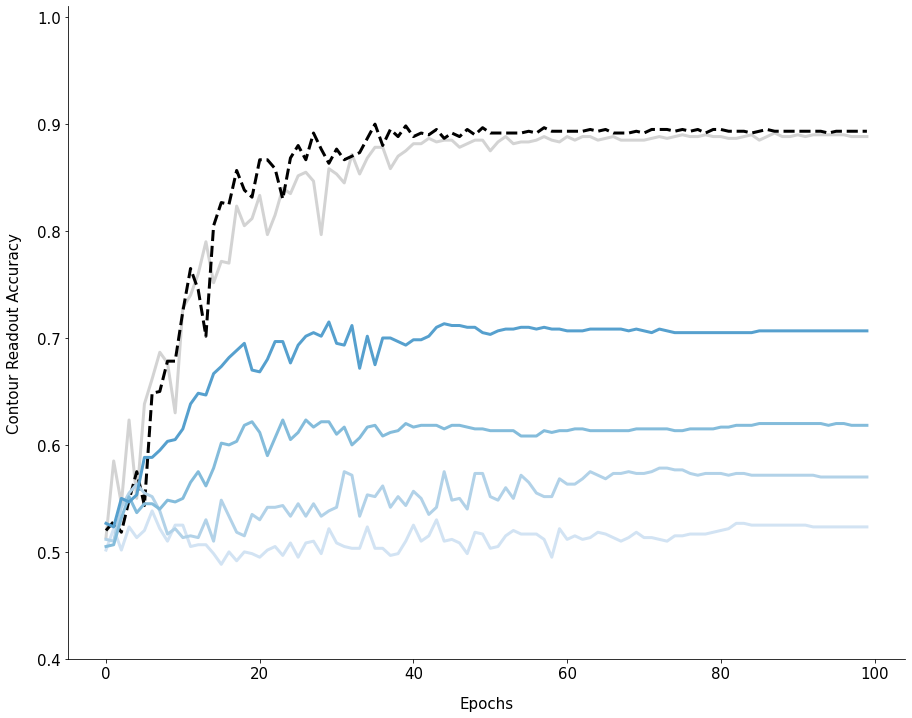

In [130]:
plt.figure(figsize=(15,12))



l1,=plt.plot(np.arange(len(alexnetbase)),alexnetbase,linewidth=3.0,color='lightgray',label='alexnet torchvision baseline (90 epochs)')
# plt.plot(np.arange(len(alexnetepoch100)),alexnetepoch100,linewidth=1.0,color='k',label='alexnet-epoch100')
plt.plot(np.arange(len(alexnetepoch50)),alexnetepoch50,linestyle='--',linewidth=3.0,color='k',label='alexnet-epoch50')


plt.plot(np.arange(len(alexnet11)),alexnet11,linewidth=3.0,color=(0.8229757785467128, 0.8898269896193771, 0.9527566320645905),label='pinholenet-11')
plt.plot(np.arange(len(alexnet17)),alexnet17,linewidth=3.0,color=(0.6965013456362937, 0.8248366013071895, 0.9092656670511342),label='pinholenet-17')

plt.plot(np.arange(len(alexnet31)),alexnet31,linewidth=3.0,color=(0.5168627450980392, 0.7357477893118032, 0.8601922337562476),label='pinholenet-31')
plt.plot(np.arange(len(alexnet33)),alexnet33,linewidth=3.0,color=(0.3363783160322953, 0.6255132641291811, 0.8067358708189158),label='pinholenet-33')











# plt.axhline(y=0.5,linestyle='--',color='r',label='chance',alpha=0.1)

plt.xlabel('Epochs',fontsize=15,labelpad=15)
plt.ylabel('Contour Readout Accuracy',fontsize=15,labelpad=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)   
plt.ylim(0.4,1.01)

    
# plt.legend(fontsize=12,frameon=False)
plt.savefig('./dev/manuscript_figures/pinholenet_contour_lineplot.png', bbox_inches='tight', format='png', dpi=600)
plt.show()

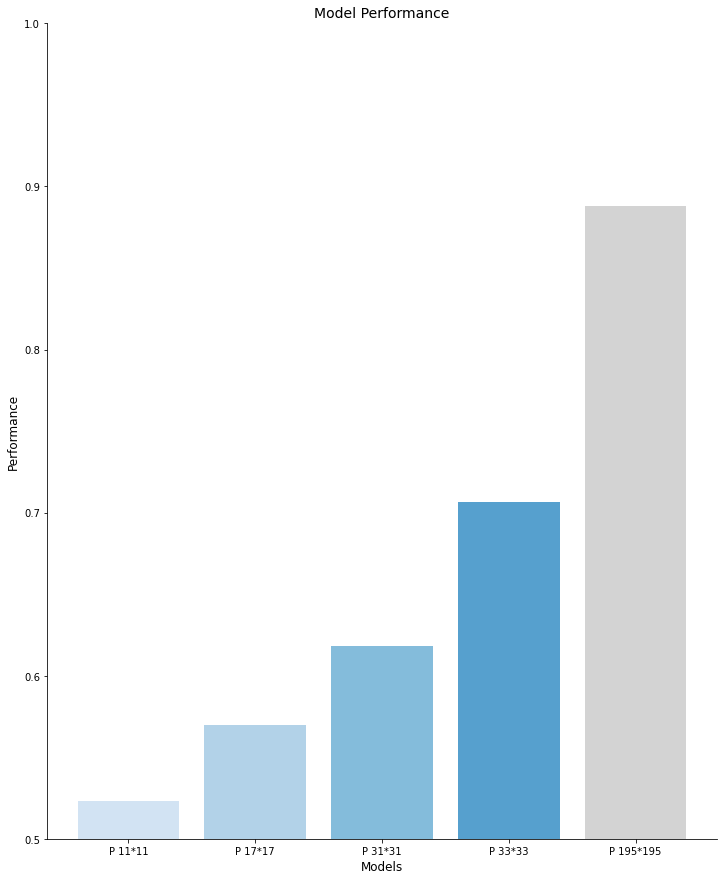

In [131]:
model_11_17_33_31_195_baseline=[0.5233333333333333, 0.5700000000000001, 0.6183333333333334, 0.7066666666666667,0.8883333333333334]

models = ['P 11*11', 'P 17*17', 'P 31*31', 'P 33*33', 'P 195*195']

# Plot bar chart
fig, ax = plt.subplots(figsize=(12,15))
bars = plt.bar(models, model_11_17_33_31_195_baseline, color=color_shades_barplot)

# Optional: Add value annotations on each bar
for bar in bars:
    yval = bar.get_height()
    # plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 5), ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.title('Model Performance', fontsize=14)

# Set the limit for y-axis (if needed)
plt.ylim(0.5, 1.0)  # Adjust the upper limit to your highest value + some margin

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('./dev/manuscript_figures/pinholenet_contour_barplot.png', bbox_inches='tight', format='png', dpi=600)

# Show plot
plt.show()


In [132]:
model_11_17_33_31_195_baseline=[0.5233333333333333, 0.5700000000000001, 0.6183333333333334, 0.7066666666666667,0.8883333333333334]
np.max(model_11_17_33_31_195_baseline) - np.min(model_11_17_33_31_195_baseline)


0.3650000000000001

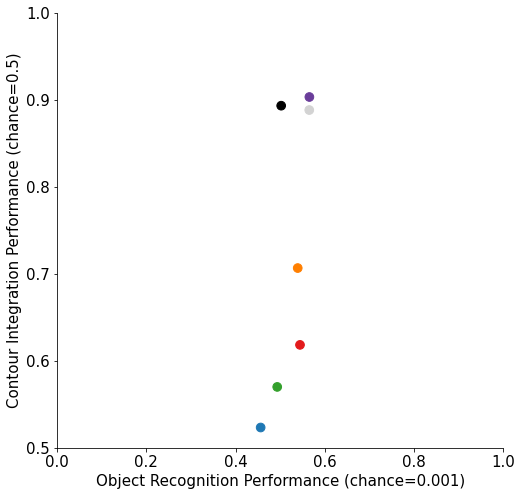

In [133]:
model_arch_names = ['pinhole11', 'pinhole17', 'pinhole31', 'pinhole33', 'alexnet-epoch100', 'alexnet-epoch50', 'alexnet-torchvision']

objecrec_performance = [0.45632, 0.49344, 0.54446, 0.53936, 0.56546, 0.50232, 0.56522]
contourinteg_performance = [0.5233333333333333, 0.5700000000000001, 0.6183333333333334, 0.7066666666666667, 0.9033333333333334, 0.8933333333333334, 0.8883333333333334]



plt.figure(figsize=(8,8))


custom_colors = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', 'k', 'lightgray']
# Ensure you have the right number of colors for the number of points
if len(custom_colors) != len(objecrec_performance):
    raise ValueError("Number of colors must match number of points")

plt.scatter(objecrec_performance, contourinteg_performance, marker='.',s=300, c=custom_colors)

# Annotating each point with its label
# for x, y, label in zip(objecrec_performance, contourinteg_performance, model_arch_names):
#     plt.text(x, y, label, fontsize=9, ha='right', va='bottom')



plt.xlim(0.0, 1.0)
plt.ylim(0.5, 1.0)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)   




plt.xlabel('Object Recognition Performance (chance=0.001)',fontsize=15)
plt.ylabel('Contour Integration Performance (chance=0.5)',fontsize=15)

plt.savefig('./dev/manuscript_figures/alexnet_pinholenet_contour_imagenet_accuracy.png', bbox_inches='tight', format='png', dpi=600)
plt.show()


In [134]:
alexnet33[-1]

0.7066666666666667

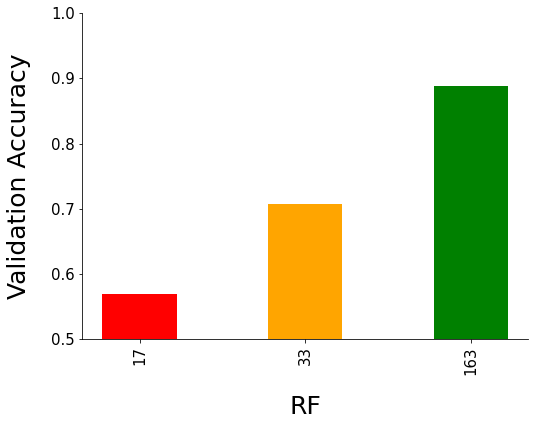

In [135]:
bars=['17','33','163']
height=[alexnet17[-1],alexnet33[-1],alexnetbase[-1]]

y_pos = np.arange(len(bars)) / 7.5  + 2
color=['r','orange','g']


plt.figure(figsize=(8,6))

plt.gca().bar(y_pos, height, align='center', width=0.06, color=color, alpha=1.0, ecolor='gray', capsize=4)


plt.xticks(y_pos, bars,fontsize=15,rotation=90)
plt.yticks(fontsize=15)

plt.ylim(0.5,1.0)

plt.ylabel('Validation Accuracy',fontsize=25,labelpad=20)
plt.xlabel('RF',fontsize=25,labelpad=20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
# plt.savefig('./dev/ccn_figures/poster/alexnet_bagnet.png', format='png', dpi=300)
plt.savefig('./dev/manuscript_figures/alexnet_bagnet.png', format='png', dpi=600)
plt.show()

### 3b. Comparing alexnet bagnet validation accuracies and RF sizes as RF increases massively

In [ ]:
alexnet_base_rf=[19,67,99,131,195,323,512,512]
pinhole_11_rf=[7,9,11,11,11,101,512,512]
pinhole_17_rf=[9,13,17,17,17,101,512,512]
pinhole_31_rf=[11,19,23,27,31,111,512,512]
pinhole_33_rf=[13,25,29,33,33,111,512,512]


x_lab=['C1','C2','C3','C4','C5','AP','F1','F2']

In [ ]:

plt.figure(figsize=(15,12))



plt.plot(np.arange(len(alexnet_base_rf)),alexnet_base_rf,linewidth=3.0,color='lightgray',label='standarad alexnet')

plt.plot(np.arange(len(pinhole_11_rf)),pinhole_11_rf,linewidth=3.0,color=(0.8229757785467128, 0.8898269896193771, 0.9527566320645905),label='pinholenet-11')
plt.plot(np.arange(len(pinhole_17_rf)),pinhole_17_rf,linewidth=3.0,color=(0.6965013456362937, 0.8248366013071895, 0.9092656670511342),label='pinholenet-17')
plt.plot(np.arange(len(pinhole_31_rf)),pinhole_31_rf,linewidth=3.0,color=(0.5168627450980392, 0.7357477893118032, 0.8601922337562476),label='pinholenet-31')
plt.plot(np.arange(len(pinhole_33_rf)),pinhole_33_rf,linewidth=3.0,color=(0.3363783160322953, 0.6255132641291811, 0.8067358708189158),label='pinholenet-33')


for i in range(len(np.arange(len(alexnet_base_rf)))):
    plt.axvline(np.arange(len(alexnet_base_rf))[i],linestyle='--',alpha=0.09,color='k')



plt.xticks(np.arange(len(alexnet_base_rf)),x_lab,fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Layer',fontsize=15,labelpad=15)
plt.ylabel('Receptive Field Size',fontsize=15,labelpad=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.legend().remove()
plt.savefig('./dev/manuscript_figures/pinholenet_contour_rf_size.png', bbox_inches='tight', format='png', dpi=600)
plt.show()

In [ ]:

# Sample dataframe
data = {
    'model_name': ['P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet',
                  'P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet',
                  'P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet'],
    'layer_name': ['AP', 'AP', 'AP', 'AP', 'AP',
                  'FC1','FC1','FC1','FC1','FC1',
                  'FC2','FC2','FC2','FC2','FC2'],
    'accuracy': [0.555,0.546,0.76,0.7967,0.915,
                0.5316,0.54,0.775,0.8383,0.9433,
                0.513,0.528,0.7633,0.8383,0.9367]
}

df = pd.DataFrame(data)

# Sample colors with RGB values
color_dict = {
    'P 11*11': (0.8229757785467128, 0.8898269896193771, 0.9527566320645905),
    'P 17*17': (0.6965013456362937, 0.8248366013071895, 0.9092656670511342),
    'P 31*31': (0.5168627450980392, 0.7357477893118032, 0.8601922337562476),
    'P 33*33': (0.3363783160322953, 0.6255132641291811, 0.8067358708189158),
    'Standard Alexnet':(0.827, 0.827, 0.827)
}

# Create bar plot
plt.figure(figsize=(15, 12))
sns.barplot(data=df, x='layer_name', y='accuracy', hue='model_name', palette=color_dict, ci=None)

# Adding titles and labels
plt.title('Model Accuracy by Layer')
plt.xlabel('Layer Name')
plt.ylabel('Accuracy')
plt.legend(title='Model Name').remove()


plt.ylim(0.5, 1.0) 


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('./dev/manuscript_figures/pinholenet_contour_training_classifier_head.png', bbox_inches='tight', format='png', dpi=600)
# Display the plot
plt.show()

In [ ]:
torch.load('../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-5_mode_finetune.pt')['metrics']['val_acc'][-1]

# 4. Looking at the AF models in heirrarchy

In [ ]:
list_layers=['features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'avgpool']

for i in range(len(list_layers)):
    list_layers[i]=list_layers[i].replace('_','.')

In [ ]:
sup_regular_finetune_files = glob.glob("../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad_af/*finetune.pt")
sup_regular_finetune_acc={'train':get_train_val_acc(sup_regular_finetune_files)[0],'val':get_train_val_acc(sup_regular_finetune_files)[1]}

In [ ]:
sup_regular_finetune_files

In [ ]:
plt.figure(figsize=(12,10))


plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),alpha=1.0,linewidth=4)
plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),'.',color='k',markersize=10,label='supervised regular finetune')
# plt.axhline(y=0.5,linestyle='--',color='r',label='chance')


# for i in range(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))):
#     plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
# plt.ylim(0.4,1.01)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.legend()
# plt.title('After 100 epochs of training')
# plt.savefig('./dev/layer_acc.svg', format='svg', dpi=1200)
# plt.savefig('./dev/ccn_figures/f1/layer_acc.png', format='png', dpi=600)
plt.show()
    
    

# 5. Comparing resnet bagnet validation accuracies

In [ ]:
# resnet50_val_acc=checkpoint['metrics']['val_acc']

# bagnet_val_acc=checkpoint['metrics']['val_acc']

# bagnet33_val_acc=checkpoint['metrics']['val_acc']

In [ ]:
# plt.figure(figsize=(10,8))
# plt.plot(np.arange(len(resnet50_val_acc)),resnet50_val_acc,linewidth=3.0,label='resnet',color='green')
# plt.plot(np.arange(len(bagnet_val_acc)),bagnet_val_acc,linewidth=3.0,label='bagnet',color='red')

# plt.axhline(y=0.5,linestyle='--',color='r',label='chance',alpha=0.1)

# plt.xlabel('Epochs',fontsize=15,labelpad=15)
# plt.ylabel('Validation Accuracy',fontsize=15,labelpad=15)

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.yticks(fontsize=15)
# plt.xticks(fontsize=15)   
# plt.ylim(0.4,1.01)

    
# plt.legend()
# plt.savefig('./dev/ccn_figures/f2/resnet_bagnet.png', format='png', dpi=1200)
# plt.show()

In [ ]:
# plt.figure(figsize=(15,10))
# plt.plot(np.arange(len(resnet50_val_acc)),resnet50_val_acc,linewidth=3.0,label='Resnet50-Vanilla',color='green')
# plt.plot(np.arange(len(bagnet_val_acc)),bagnet_val_acc,linewidth=3.0,label='Resnet50-Bagnet: RF 9px',color='red')
# plt.plot(np.arange(len(bagnet33_val_acc)),bagnet33_val_acc,linewidth=3.0,label='Resnet50-Bagnet: RF 33px',color='blue')

# plt.axhline(y=0.5,linestyle='--',color='r',label='chance',alpha=0.1)

# plt.xlabel('Epochs',fontsize=15,labelpad=15)
# plt.ylabel('Validation Accuracy',fontsize=15,labelpad=15)

# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.yticks(fontsize=15)
# plt.xticks(fontsize=15)   
# plt.ylim(0.4,1.01)

    
# plt.legend()
# plt.savefig('./dev/ccn_figures/f2/resnet_bagnet_bagnet33.png', format='png', dpi=1200)
# plt.show()

# 6. Interactive explorer

In [136]:
files = glob.glob("../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/*finetune.pt")
files

['../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_features-2_mode_finetune.pt',
 '../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-4_mode_finetune.pt',
 '../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-3_mode_finetune.pt',
 '../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt',
 '../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-0_mode_finetune.pt',
 '../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_features-0_mode_finetune.pt',
 '../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_features-6_mode_finetune.pt',
 '../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/mod

In [137]:
@interact(selected_file=files)
def plot_diff_distribution_categories(selected_file):
    checkpoint=torch.load(selected_file)
    
    
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)
    plt.plot(np.arange(len(checkpoint['metrics']['train_acc'])),checkpoint['metrics']['train_acc'],label='train')
    plt.plot(np.arange(len(checkpoint['metrics']['val_acc'])),checkpoint['metrics']['val_acc'],label='val')
    plt.axhline(y=0.5,linestyle='--',color='r',label='chance')
    
    plt.ylabel('Accuracy',fontsize=10)
    plt.xlabel('Epochs',fontsize=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.ylim(0.4,1.01)
    plt.legend()
    
    
    plt.subplot(1,2,2)
    plt.plot(np.arange(len(checkpoint['metrics']['train_loss'])),checkpoint['metrics']['train_loss'],label='train')
    plt.plot(np.arange(len(checkpoint['metrics']['val_loss'])),checkpoint['metrics']['val_loss'],label='val')
    plt.ylabel('Loss',fontsize=10)
    plt.xlabel('Epochs',fontsize=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    
    
    
    plt.show()

interactive(children=(Dropdown(description='selected_file', options=('../../dev/new_ccn23/alexnet_regimagenet_…

# 7. Accuracy accross architecture/model heirarchary

In [ ]:
list_layers=['features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

for i in range(len(list_layers)):
    list_layers[i]=list_layers[i].replace('_','.')

In [ ]:
sup_regular_finetune_files = glob.glob("../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/*finetune.pt")
sup_regular_finetune_acc={'train':get_train_val_acc(sup_regular_finetune_files)[0],'val':get_train_val_acc(sup_regular_finetune_files)[1]}

In [ ]:
sup_regular_finetune_acc

In [ ]:
sup_regular_finetune_files

In [ ]:
plt.figure(figsize=(12,10))


plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),alpha=1.0,linewidth=4)
plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),'.',color='k',markersize=10,label='supervised regular finetune')
plt.axhline(y=0.5,linestyle='--',color='r',label='chance')


# for i in range(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))):
#     plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.4,1.01)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.legend()
# plt.title('After 100 epochs of training')
# plt.savefig('./dev/layer_acc.svg', format='svg', dpi=1200)
# plt.savefig('./dev/ccn_figures/f1/layer_acc.png', format='png', dpi=600)
plt.show()
    
    

In [ ]:
sup_regular_frozen_files =  glob.glob("../../dev/new_ccn23/alexnet_regimagenet_categ_frozen_broad/*frozen.pt")
sup_regular_frozen_acc={'train':get_train_val_acc(sup_regular_frozen_files)[0],'val':get_train_val_acc(sup_regular_frozen_files)[1]}

In [ ]:
plt.figure(figsize=(12,10))


plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),alpha=0.8,linewidth=4)
plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),'.',color='k',markersize=10,label='supervised regular finetune')


plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),alpha=0.4,color='orange',linewidth=4)
plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),'.',alpha=0.6,color='k',markersize=10,label='supervised regular finetune')



plt.axhline(y=0.5,linestyle='--',color='r',label='chance')


for i in range(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.4,1.01)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.legend()
# plt.title('After 100 epochs of training')
# plt.savefig('./dev/layer_acc.svg', format='svg', dpi=1200)
# plt.savefig('./dev/ccn_figures/poster/finetune_frozen_layer_acc.png', format='png', dpi=600)
plt.show()
    
    

In [ ]:
plt.figure(figsize=(12,10))


plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),alpha=1.0,linewidth=4)
plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),'.',color='k',markersize=10,label='supervised regular finetune')


plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),alpha=1.0,linewidth=4)
plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),'.',color='k',markersize=10,label='supervised regular finetune')



plt.axhline(y=0.5,linestyle='--',color='r',label='chance')


# for i in range(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))):
#     plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),(np.arange(len(list_layers)) + 1)/len(list_layers),rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.4,1.01)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.legend()
# plt.title('After 100 epochs of training')
# plt.savefig('./dev/layer_acc.svg', format='svg', dpi=1200)
# plt.savefig('./dev/ccn_figures/f4/finetune_frozen_layer_acc.png', format='png', dpi=600)
plt.show()
    
    

### 7b. Accuracy accross architecture/model heirarchary comparing stylized and regular frozen

In [ ]:
list_layers=['features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

for i in range(len(list_layers)):
    list_layers[i]=list_layers[i].replace('_','.')

In [ ]:
sup_regular_finetune_files = glob.glob("../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/*finetune.pt")
sup_regular_finetune_acc={'train':get_train_val_acc(sup_regular_finetune_files)[0],'val':get_train_val_acc(sup_regular_finetune_files)[1]}

In [ ]:
sup_regular_frozen_files =  glob.glob("../../dev/new_ccn23/alexnet_regimagenet_categ_frozen_broad/*frozen.pt")
sup_regular_frozen_acc={'train':get_train_val_acc(sup_regular_frozen_files)[0],'val':get_train_val_acc(sup_regular_frozen_files)[1]}

In [ ]:
stylized_regular_frozen_files =  glob.glob("../../dev/new_ccn23/alexnet-styim-categ_frozen_broad/*frozen.pt")
stylized_regular_frozen_acc={'train':get_train_val_acc(stylized_regular_frozen_files)[0],'val':get_train_val_acc(stylized_regular_frozen_files)[1]}




In [ ]:
plt.figure(figsize=(12,10))


plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),alpha=0.8,linewidth=4,label='regular finetune')
plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),'.',color='k',markersize=10)


plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),alpha=0.4,color='orange',linewidth=4,label='regular frozen')
plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),'.',alpha=0.6,color='k',markersize=10)


plt.plot(np.arange(len(get_list_acc(stylized_regular_frozen_acc['val'],list_layers))),get_list_acc(stylized_regular_frozen_acc['val'],list_layers),alpha=0.4,color='g',linewidth=4,label='stylized frozen')
plt.plot(np.arange(len(get_list_acc(stylized_regular_frozen_acc['val'],list_layers))),get_list_acc(stylized_regular_frozen_acc['val'],list_layers),'.',alpha=0.6,color='k',markersize=10)



plt.axhline(y=0.5,linestyle='--',color='r',label='chance')


for i in range(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.4,1.01)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
# plt.title('After 100 epochs of training')
# plt.savefig('./dev/layer_acc.svg', format='svg', dpi=1200)
# plt.savefig('./dev/ccn_figures/poster/finetune_frozen_layer_acc.png', format='png', dpi=600)
plt.show()
    
    

### 7c. Accuracy accross architecture/model heirarchary comparing stylized and regular frozen (+ adding random/untrained models too)

In [ ]:
list_layers=['features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

for i in range(len(list_layers)):
    list_layers[i]=list_layers[i].replace('_','.')

In [ ]:
sup_regular_finetune_files = glob.glob("../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/*finetune.pt")
sup_regular_finetune_acc={'train':get_train_val_acc(sup_regular_finetune_files)[0],'val':get_train_val_acc(sup_regular_finetune_files)[1]}

In [ ]:
stylized_regular_finetune_files =  glob.glob("../../dev/new_ccn23/alexnet-styim-categ_finetune_broad/*finetune.pt")
stylized_regular_finetune_acc={'train':get_train_val_acc(stylized_regular_finetune_files)[0],'val':get_train_val_acc(stylized_regular_finetune_files)[1]}

In [ ]:
random_regular_finetune_files =  glob.glob("../../dev/new_ccn23/alexnet-random-nodata-notask_finetune_broad/*finetune.pt")
random_regular_finetune_acc={'train':get_train_val_acc(random_regular_finetune_files)[0],'val':get_train_val_acc(random_regular_finetune_files)[1]}

In [ ]:
sup_regular_frozen_files =  glob.glob("../../dev/new_ccn23/alexnet_regimagenet_categ_frozen_broad/*frozen.pt")
sup_regular_frozen_acc={'train':get_train_val_acc(sup_regular_frozen_files)[0],'val':get_train_val_acc(sup_regular_frozen_files)[1]}

In [ ]:
stylized_regular_frozen_files =  glob.glob("../../dev/new_ccn23/alexnet-styim-categ_frozen_broad/*frozen.pt")
stylized_regular_frozen_acc={'train':get_train_val_acc(stylized_regular_frozen_files)[0],'val':get_train_val_acc(stylized_regular_frozen_files)[1]}

In [ ]:
random_regular_frozen_files =  glob.glob("../../dev/new_ccn23/alexnet-random-nodata-notask_frozen_broad/*frozen.pt")
random_regular_frozen_acc={'train':get_train_val_acc(random_regular_frozen_files)[0],'val':get_train_val_acc(random_regular_frozen_files)[1]}

In [ ]:
plt.figure(figsize=(12,10))


plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),alpha=0.8,linewidth=4,label='or finetune')
plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),'.',color='k',markersize=10)


plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),alpha=0.4,color='orange',linewidth=4,label='or frozen')
plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),'.',alpha=0.6,color='k',markersize=10)


plt.plot(np.arange(len(get_list_acc(stylized_regular_frozen_acc['val'],list_layers))),get_list_acc(stylized_regular_frozen_acc['val'],list_layers),alpha=0.4,color='g',linewidth=4,label='stylized frozen')
plt.plot(np.arange(len(get_list_acc(stylized_regular_frozen_acc['val'],list_layers))),get_list_acc(stylized_regular_frozen_acc['val'],list_layers),'.',alpha=0.6,color='k',markersize=10)




plt.plot(np.arange(len(get_list_acc(random_regular_frozen_acc['val'],list_layers))),get_list_acc(random_regular_frozen_acc['val'],list_layers),alpha=0.4,color='indigo',linewidth=4,label='random frozen')
plt.plot(np.arange(len(get_list_acc(random_regular_frozen_acc['val'],list_layers))),get_list_acc(random_regular_frozen_acc['val'],list_layers),'.',alpha=0.6,color='k',markersize=10)




# plt.plot(np.arange(len(get_list_acc(random_regular_finetune_acc['val'],list_layers))),get_list_acc(random_regular_finetune_acc['val'],list_layers),alpha=0.4,color='deeppink',linewidth=4,label='random finetune')
# plt.plot(np.arange(len(get_list_acc(random_regular_finetune_acc['val'],list_layers))),get_list_acc(random_regular_finetune_acc['val'],list_layers),'.',alpha=0.6,color='k',markersize=10)






plt.axhline(y=0.5,linestyle='--',alpha=0.3,color='r',label='chance')


for i in range(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.4,1.01)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
# plt.title('After 100 epochs of training')
# plt.savefig('./dev/layer_acc.svg', format='svg', dpi=1200)
plt.savefig('./dev/manuscript_figures/selected_broad_models.png', format='png', dpi=600)
plt.show()
    
    

In [ ]:
plt.figure(figsize=(12,10))


plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),alpha=0.8,color='orange',linewidth=4,label='or finetune')
plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),'.',color='k',markersize=10)


plt.plot(np.arange(len(get_list_acc(stylized_regular_finetune_acc['val'],list_layers))),get_list_acc(stylized_regular_finetune_acc['val'],list_layers),alpha=0.8,color='g',linewidth=4,label='stylized finetune')
plt.plot(np.arange(len(get_list_acc(stylized_regular_finetune_acc['val'],list_layers))),get_list_acc(stylized_regular_finetune_acc['val'],list_layers),'.',color='k',markersize=10)



plt.plot(np.arange(len(get_list_acc(random_regular_finetune_acc['val'],list_layers))),get_list_acc(random_regular_finetune_acc['val'],list_layers),alpha=0.8,color='indigo',linewidth=4,label='random finetune')
plt.plot(np.arange(len(get_list_acc(random_regular_finetune_acc['val'],list_layers))),get_list_acc(random_regular_finetune_acc['val'],list_layers),'.',color='k',markersize=10)








plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),':',alpha=0.7,color='orange',linewidth=3,label='or frozen')
plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),'.',color='k',markersize=10)


plt.plot(np.arange(len(get_list_acc(stylized_regular_frozen_acc['val'],list_layers))),get_list_acc(stylized_regular_frozen_acc['val'],list_layers),':',alpha=0.7,color='g',linewidth=3,label='stylized frozen')
plt.plot(np.arange(len(get_list_acc(stylized_regular_frozen_acc['val'],list_layers))),get_list_acc(stylized_regular_frozen_acc['val'],list_layers),'.',color='k',markersize=10)




plt.plot(np.arange(len(get_list_acc(random_regular_frozen_acc['val'],list_layers))),get_list_acc(random_regular_frozen_acc['val'],list_layers),':',alpha=0.7,color='indigo',linewidth=3,label='random frozen')
plt.plot(np.arange(len(get_list_acc(random_regular_frozen_acc['val'],list_layers))),get_list_acc(random_regular_frozen_acc['val'],list_layers),'.',color='k',markersize=10)











plt.axhline(y=0.5,linestyle='--',alpha=0.3,color='r',label='chance')


for i in range(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.4,1.01)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
# plt.title('After 100 epochs of training')
# plt.savefig('./dev/layer_acc.svg', format='svg', dpi=1200)
plt.savefig('./dev/manuscript_figures/all_broad_models.png', format='png', dpi=600)
plt.show()
    
    

# 8: Accuracy accross architecture/model heirarchary comparing stylized and regular frozen (+ adding random/untrained models too) - Getting confidence interval bars - Pub
* Computing the accuracy again usiing the images

### Functions

In [ ]:
def get_prediction(model_file_paths):
    model_valacc_scores={}
    for file in tqdm(model_file_paths):

        # Model
        checkpoint=torch.load(file)
        # loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device='cpu')
        loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
        loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
        
        change_train_eval_mode(loaded_spliced_model,loaded_spliced_model.fine_tune,train_eval_mode='eval')




        model_valacc_scores[checkpoint['training_config']['layer_name']]=np.array([])
        for (inputs, b, d, alpha, nel, labels, record) in tqdm(val_loader_norm,disable=True):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs= loaded_spliced_model.forward(inputs)
            _, preds = torch.max(outputs, 1)

            model_valacc_scores[checkpoint['training_config']['layer_name']]=np.concatenate((model_valacc_scores[checkpoint['training_config']['layer_name']],(preds == labels).float().cpu().numpy()))
    
    
    return model_valacc_scores

In [ ]:
def get_list_acc_mean_std_ci(sal_dict,list_layers):
    mean_sal=[]
    std_sal=[]
    confint_sal=[]
    
    
    confint_lower=[]
    confint_upper=[]
    
    for i in range(len(list_layers)):
        # layer=list_layers[i].replace('_','.')
        layer=list_layers[i]
        if layer in sal_dict.keys():
            mean_sal.append(np.mean(sal_dict[layer]))
            
            std_sal.append(np.std(sal_dict[layer],ddof=1))
            
            confint_sal.append(1.96*(np.std(sal_dict[layer],ddof=1) / np.sqrt(len(sal_dict[layer]))))
            
            confint_lower.append(np.percentile(sal_dict[layer], 2.5))
            confint_upper.append(np.percentile(sal_dict[layer], 97.5))
            
    return mean_sal,std_sal,confint_sal,confint_lower,confint_upper


### Hyperparameters and validation dataset extraction

In [ ]:
visual_diet_config={'root_directory':os.path.expanduser('/home/jovyan/work/Datasets/contour_integration/model-training/config_0/'),'get_B':[0,15,30,45,60,75],'get_D':[32],'get_A':[0],'get_numElements':[12]}



In [ ]:
root_directory=visual_diet_config['root_directory']
get_B=visual_diet_config['get_B']
get_D=visual_diet_config['get_D']
get_A=visual_diet_config['get_A']
get_numElements=visual_diet_config['get_numElements']

In [ ]:
img_dim=512

In [ ]:
batch_size=32
num_workers=8
device = torch.device('cuda:'+'3')
# device = 'cpu'
device

In [ ]:
# normalize images using parameters from the training image set
data_transform = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

data_transform_without_norm = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor()                    
 ])

In [ ]:
val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=get_B,get_D=get_D,get_A=get_A,get_numElements=get_numElements)
val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)


### Collecting all the accuracy data

In [ ]:
sup_regular_finetune_files = glob.glob("../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/*finetune.pt")
sup_regular_finetune_acc={'train':get_train_val_acc(sup_regular_finetune_files)[0],'val':get_train_val_acc(sup_regular_finetune_files)[1]}
sup_regular_finetune_predictions=get_prediction(sup_regular_finetune_files)

In [ ]:
# stylized_regular_finetune_files =  glob.glob("../../dev/new_ccn23/alexnet-styim-categ_finetune_broad/*finetune.pt")
# stylized_regular_finetune_acc={'train':get_train_val_acc(stylized_regular_finetune_files)[0],'val':get_train_val_acc(stylized_regular_finetune_files)[1]}
# stylized_regular_finetune_predictions=get_prediction(stylized_regular_finetune_files)

In [ ]:
# random_regular_finetune_files =  glob.glob("../../dev/new_ccn23/alexnet-random-nodata-notask_finetune_broad/*finetune.pt")
# random_regular_finetune_acc={'train':get_train_val_acc(random_regular_finetune_files)[0],'val':get_train_val_acc(random_regular_finetune_files)[1]}
# random_regular_finetune_predictions=get_prediction(random_regular_finetune_files)

In [ ]:
sup_regular_frozen_files =  glob.glob("../../dev/new_ccn23/alexnet_regimagenet_categ_frozen_broad/*frozen.pt")
sup_regular_frozen_acc={'train':get_train_val_acc(sup_regular_frozen_files)[0],'val':get_train_val_acc(sup_regular_frozen_files)[1]}
sup_regular_frozen_predictions=get_prediction(sup_regular_frozen_files)



In [ ]:
stylized_regular_frozen_files =  glob.glob("../../dev/new_ccn23/alexnet-styim-categ_frozen_broad/*frozen.pt")
stylized_regular_frozen_acc={'train':get_train_val_acc(stylized_regular_frozen_files)[0],'val':get_train_val_acc(stylized_regular_frozen_files)[1]}
stylized_regular_frozen_predictions=get_prediction(stylized_regular_frozen_files)



In [ ]:
random_regular_frozen_files =  glob.glob("../../dev/new_ccn23/alexnet-random-nodata-notask_frozen_broad/*frozen.pt")
random_regular_frozen_acc={'train':get_train_val_acc(random_regular_frozen_files)[0],'val':get_train_val_acc(random_regular_frozen_files)[1]}
random_regular_frozen_predictions=get_prediction(random_regular_frozen_files)



### Plotting all the accuracy data

In [ ]:
list_layers=['features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

for i in range(len(list_layers)):
    list_layers[i]=list_layers[i].replace('_','.')

### Plots

In [ ]:
plt.figure(figsize=(12,10))


plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),alpha=0.8,linewidth=4,label='or finetune')
plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),'.',color='k',markersize=10)


plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),alpha=0.4,color='orange',linewidth=4,label='or frozen')
plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),'.',alpha=0.6,color='k',markersize=10)


plt.plot(np.arange(len(get_list_acc(stylized_regular_frozen_acc['val'],list_layers))),get_list_acc(stylized_regular_frozen_acc['val'],list_layers),alpha=0.4,color='g',linewidth=4,label='stylized frozen')
plt.plot(np.arange(len(get_list_acc(stylized_regular_frozen_acc['val'],list_layers))),get_list_acc(stylized_regular_frozen_acc['val'],list_layers),'.',alpha=0.6,color='k',markersize=10)


plt.plot(np.arange(len(get_list_acc(random_regular_frozen_acc['val'],list_layers))),get_list_acc(random_regular_frozen_acc['val'],list_layers),alpha=0.4,color='indigo',linewidth=4,label='random frozen')
plt.plot(np.arange(len(get_list_acc(random_regular_frozen_acc['val'],list_layers))),get_list_acc(random_regular_frozen_acc['val'],list_layers),'.',alpha=0.6,color='k',markersize=10)


plt.axhline(y=0.5,linestyle='--',alpha=0.3,color='r',label='chance')


for i in range(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.4,1.01)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.show()
    
    

In [ ]:
plt.figure(figsize=(12,10))


mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(sup_regular_finetune_predictions,list_layers)
plt.plot(np.arange(len(mean_sal)),mean_sal,alpha=0.8,linewidth=4)
plt.plot(np.arange(len(mean_sal)),mean_sal,'.',color='k',markersize=10,label='or finetune')
plt.fill_between(np.arange(len(mean_sal)), np.array(mean_sal) -  np.array(confint_sal),  np.array(mean_sal) +  np.array(confint_sal), color='C0', alpha=0.2)


mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(sup_regular_frozen_predictions,list_layers)
plt.plot(np.arange(len(mean_sal)),mean_sal,alpha=0.8,color='orange',linewidth=4)
plt.plot(np.arange(len(mean_sal)),mean_sal,'.',color='k',markersize=10,label='or frozen')
plt.fill_between(np.arange(len(mean_sal)), np.array(mean_sal) -  np.array(confint_sal),  np.array(mean_sal) +  np.array(confint_sal), color='orange', alpha=0.2)



mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(stylized_regular_frozen_predictions,list_layers)
plt.plot(np.arange(len(mean_sal)),mean_sal,alpha=0.8,color='g',linewidth=4)
plt.plot(np.arange(len(mean_sal)),mean_sal,'.',color='k',markersize=10,label='stylized frozen')
plt.fill_between(np.arange(len(mean_sal)), np.array(mean_sal) -  np.array(confint_sal),  np.array(mean_sal) +  np.array(confint_sal), color='g', alpha=0.2)



mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(random_regular_frozen_predictions,list_layers)
plt.plot(np.arange(len(mean_sal)),mean_sal,alpha=0.8,color='indigo',linewidth=4)
plt.plot(np.arange(len(mean_sal)),mean_sal,'.',color='k',markersize=10,label='random frozen')
plt.fill_between(np.arange(len(mean_sal)), np.array(mean_sal) -  np.array(confint_sal),  np.array(mean_sal) +  np.array(confint_sal), color='indigo', alpha=0.2)



plt.axhline(y=0.5,linestyle='--',alpha=0.3,color='r',label='chance')


for i in range(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.4,1.01)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.savefig('./dev/manuscript_figures/selected_broad_models_ci.png', format='png', dpi=600)
plt.show()
    
    

In [ ]:
plt.figure(figsize=(14,10))


spacing_x=2
jitter_stylized=0.4

color_or_finetune=(78/255,121/255,180/255)
color_or_frozen=(209/255,111/255,28/255)
color_stylized_frozen=(231/255,168/255,34/255)

error_bar_width=3
error_bar_cap=4



mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(sup_regular_finetune_predictions,list_layers)
plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, 
             yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='o', marker='o', color=color_or_finetune, markersize=10, 
             label='or finetune', alpha=0.8)




mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(sup_regular_frozen_predictions,list_layers)
plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, 
             yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='s', marker='s', color=color_or_frozen, markersize=10, 
             label='or frozen', alpha=0.8)



mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(stylized_regular_frozen_predictions,list_layers)
plt.errorbar((np.arange(len(mean_sal)) * spacing_x) + jitter_stylized, mean_sal, 
             yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='^', marker='^', color=color_stylized_frozen, markersize=10, 
             label='stylized frozen', alpha=0.8)



mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(random_regular_frozen_predictions,list_layers)
plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, 
             yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='d', marker='d', color='gray', markersize=15, 
             label='random frozen', alpha=0.8)



plt.axhline(y=0.5,linestyle='--',alpha=0.3,color='r',label='chance')


# for i in range(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))):
#     plt.axvline(i*2,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))) * spacing_x,list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.4,1.01)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.savefig('./dev/manuscript_figures/selected_broad_models_ci.png', format='png', dpi=600)
plt.show()
    
    

#### **Pub**

In [ ]:
plt.figure(figsize=(14,10))


spacing_x=2
jitter_stylized=0.4

color_or_finetune=(78/255,121/255,180/255)
color_or_frozen=(209/255,111/255,28/255)
color_stylized_frozen=(231/255,168/255,34/255)

error_bar_width=3
error_bar_cap=4



mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(sup_regular_finetune_predictions,list_layers)
plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, 
             yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='o', marker='o', color=color_or_finetune, markersize=10, 
             label='or finetune', alpha=0.8)




mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(sup_regular_frozen_predictions,list_layers)
plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, 
             yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='s', marker='o', color=color_or_frozen, markersize=10, 
             label='or frozen', alpha=0.8)



mean_sal,std_sal,confint_sal,confint_lower,confint_upper=get_list_acc_mean_std_ci(random_regular_frozen_predictions,list_layers)
plt.errorbar(np.arange(len(mean_sal)) * spacing_x, mean_sal, 
             yerr=confint_sal, 
             capsize=error_bar_cap,elinewidth=error_bar_width,fmt='d', marker='o', color='gray', markersize=10, 
             label='random frozen', alpha=0.8)



plt.axhline(y=0.5,linestyle='--',alpha=0.3,color='r',label='chance')


# for i in range(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))):
#     plt.axvline(i*2,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))) * spacing_x,list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.4,1.01)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.savefig('./dev/manuscript_figures/f2_frozen_finetuning_comparison.png', format='png', dpi=600)
plt.show()
    
    

# 9: Accuracy afor all images for selected models (not heiirarchy but any) - Pub
* Computing the accuracy again usiing the images

### Functions

In [15]:
def get_prediction(model_file_paths):
    model_valacc_scores={}
    for file in tqdm(model_file_paths):

        # Model
        checkpoint=torch.load(file)
        # loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device='cpu')
        loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
        loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
        
        change_train_eval_mode(loaded_spliced_model,loaded_spliced_model.fine_tune,train_eval_mode='eval')




        model_valacc_scores[file.split('/')[-1]]=np.array([])
        for (inputs, b, d, alpha, nel, labels, record) in tqdm(val_loader_norm,disable=True):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs= loaded_spliced_model.forward(inputs)
            _, preds = torch.max(outputs, 1)

            model_valacc_scores[file.split('/')[-1]]=np.concatenate((model_valacc_scores[file.split('/')[-1]],(preds == labels).float().cpu().numpy()))
    
    
    return model_valacc_scores

In [16]:
def get_list_acc_mean_std_ci(sal_dict):
    mean_sal=[]
    std_sal=[]
    confint_sal=[]
    
    
    confint_lower=[]
    confint_upper=[]
    
    list_keys=[]
    
    for key in sal_dict.keys():
        
        
        mean_sal.append(np.mean(sal_dict[key]))

        std_sal.append(np.std(sal_dict[key],ddof=1))

        confint_sal.append(1.96*(np.std(sal_dict[key],ddof=1) / np.sqrt(len(sal_dict[key]))))

        confint_lower.append(np.percentile(sal_dict[key], 2.5))
        confint_upper.append(np.percentile(sal_dict[key], 97.5))
        
        list_keys.append(key)
            
    return mean_sal,std_sal,confint_sal,confint_lower,confint_upper, list_keys


### Hyperparameters and validation dataset extraction

In [17]:
visual_diet_config={'root_directory':os.path.expanduser('/home/jovyan/work/Datasets/contour_integration/model-training/config_0/'),'get_B':[0,15,30,45,60,75],'get_D':[32],'get_A':[0],'get_numElements':[12]}



In [18]:
root_directory=visual_diet_config['root_directory']
get_B=visual_diet_config['get_B']
get_D=visual_diet_config['get_D']
get_A=visual_diet_config['get_A']
get_numElements=visual_diet_config['get_numElements']

In [19]:
img_dim=512

In [20]:
batch_size=2
num_workers=8
device = torch.device('cuda:'+'3')
# device = 'cpu'
device

device(type='cuda', index=3)

In [21]:
# normalize images using parameters from the training image set
data_transform = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

data_transform_without_norm = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor()                    
 ])

In [22]:
val_dataset_norm = Contour_Dataset(root=root_directory,transform=data_transform,train=False,get_B=get_B,get_D=get_D,get_A=get_A,get_numElements=get_numElements)
val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)


### Collecting all the accuracy data

In [23]:
bagnet_conv5_finetune_files = ['../../dev/new_ccn23/alexnet-bagnet11_regimagenet_categ_finetune_broad/model_alexnet-bagnet11-regim-categ_layer_features-9_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet-bagnet17_regimagenet_categ_finetune_broad/model_alexnet-bagnet17-regim-categ_layer_features-9_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet-bagnet31_regimagenet_categ_finetune_broad/model_alexnet-bagnet31-regim-categ_layer_features-9_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet-bagnet33_regimagenet_categ_finetune_broad/model_alexnet-bagnet33-regim-categ_layer_features-9_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_features-12_mode_finetune.pt']
bagnet_conv5_finetune_predictions=get_prediction(bagnet_conv5_finetune_files)







bagnet_ap_finetune_files = ['../../dev/new_ccn23/alexnet-bagnet11_regimagenet_categ_finetune_broad/model_alexnet-bagnet11-regim-categ_layer_avgpool_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet-bagnet17_regimagenet_categ_finetune_broad/model_alexnet-bagnet17-regim-categ_layer_avgpool_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet-bagnet31_regimagenet_categ_finetune_broad/model_alexnet-bagnet31-regim-categ_layer_avgpool_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet-bagnet33_regimagenet_categ_finetune_broad/model_alexnet-bagnet33-regim-categ_layer_avgpool_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt']
bagnet_ap_finetune_predictions=get_prediction(bagnet_ap_finetune_files)








bagnet_fc1_finetune_files = ['../../dev/new_ccn23/alexnet-bagnet11_regimagenet_categ_finetune_broad/model_alexnet-bagnet11-regim-categ_layer_classifier-2_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet-bagnet17_regimagenet_categ_finetune_broad/model_alexnet-bagnet17-regim-categ_layer_classifier-2_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet-bagnet31_regimagenet_categ_finetune_broad/model_alexnet-bagnet31-regim-categ_layer_classifier-2_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet-bagnet33_regimagenet_categ_finetune_broad/model_alexnet-bagnet33-regim-categ_layer_classifier-2_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-2_mode_finetune.pt']
bagnet_fc1_finetune_predictions=get_prediction(bagnet_fc1_finetune_files)







bagnet_fc2_finetune_files = ['../../dev/new_ccn23/alexnet-bagnet11_regimagenet_categ_finetune_broad/model_alexnet-bagnet11-regim-categ_layer_classifier-5_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet-bagnet17_regimagenet_categ_finetune_broad/model_alexnet-bagnet17-regim-categ_layer_classifier-5_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet-bagnet31_regimagenet_categ_finetune_broad/model_alexnet-bagnet31-regim-categ_layer_classifier-5_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet-bagnet33_regimagenet_categ_finetune_broad/model_alexnet-bagnet33-regim-categ_layer_classifier-5_mode_finetune.pt',
                        '../../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-5_mode_finetune.pt']
bagnet_fc2_finetune_predictions=get_prediction(bagnet_fc2_finetune_files)

  0%|          | 0/5 [00:00<?, ?it/s]

... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet11_72211_final_weights_pytorch2-d37f3073cd.pth
... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet17_93311_final_weights_pytorch2-b051786873.pth
... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet31_115333_final_weights_pytorch2-25355f56ff.pth
... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet33_137331_final_weights_pytorch2-3b5d8dae71.pth


  0%|          | 0/5 [00:00<?, ?it/s]

... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet11_72211_final_weights_pytorch2-d37f3073cd.pth
... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet17_93311_final_weights_pytorch2-b051786873.pth
... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet31_115333_final_weights_pytorch2-25355f56ff.pth
... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet33_137331_final_weights_pytorch2-3b5d8dae71.pth


  0%|          | 0/5 [00:00<?, ?it/s]

... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet11_72211_final_weights_pytorch2-d37f3073cd.pth
... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet17_93311_final_weights_pytorch2-b051786873.pth
... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet31_115333_final_weights_pytorch2-25355f56ff.pth
... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet33_137331_final_weights_pytorch2-3b5d8dae71.pth


  0%|          | 0/5 [00:00<?, ?it/s]

... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet11_72211_final_weights_pytorch2-d37f3073cd.pth
... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet17_93311_final_weights_pytorch2-b051786873.pth
... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet31_115333_final_weights_pytorch2-25355f56ff.pth
... loading checkpoint: ../../dev/base_model_weights/alexnet_bagnet33_137331_final_weights_pytorch2-3b5d8dae71.pth


In [112]:
bagnet_conv5_mean_sal, _, bagnet_conv5_confint_sal, _, _, _ =get_list_acc_mean_std_ci(bagnet_conv5_finetune_predictions)


bagnet_ap_mean_sal, _, bagnet_ap_confint_sal, _, _, _ =get_list_acc_mean_std_ci(bagnet_ap_finetune_predictions)


bagnet_fc1_mean_sal, _, bagnet_fc1_confint_sal, _, _, _ =get_list_acc_mean_std_ci(bagnet_fc1_finetune_predictions)


bagnet_fc2_mean_sal, _, bagnet_fc2_confint_sal, _, _, _ =get_list_acc_mean_std_ci(bagnet_fc2_finetune_predictions)


### Plotting for bagnets

In [113]:
color_shades_barplot=[(0.8229757785467128, 0.8898269896193771, 0.9527566320645905),
                      (0.6965013456362937, 0.8248366013071895, 0.9092656670511342),
                      (0.5168627450980392, 0.7357477893118032, 0.8601922337562476),
                      (0.3363783160322953, 0.6255132641291811, 0.8067358708189158),
                      (0.8275, 0.8275, 0.8275)]

### Hand designed plot

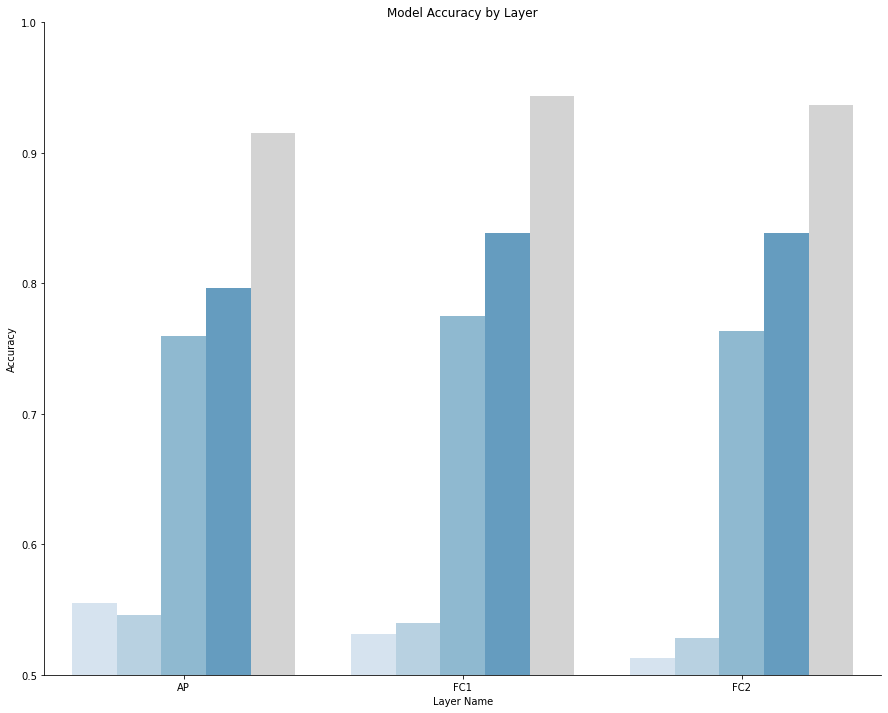

In [114]:
# Sample dataframe
data = {
    'model_name': ['P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet',
                  'P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet',
                  'P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet'],
    'layer_name': ['AP', 'AP', 'AP', 'AP', 'AP',
                  'FC1','FC1','FC1','FC1','FC1',
                  'FC2','FC2','FC2','FC2','FC2'],
    'accuracy': [0.555,0.546,0.76,0.7967,0.915,
                0.5316,0.54,0.775,0.8383,0.9433,
                0.513,0.528,0.7633,0.8383,0.9367]
}

df = pd.DataFrame(data)

# Sample colors with RGB values
color_dict = {
    'P 11*11': (0.8229757785467128, 0.8898269896193771, 0.9527566320645905),
    'P 17*17': (0.6965013456362937, 0.8248366013071895, 0.9092656670511342),
    'P 31*31': (0.5168627450980392, 0.7357477893118032, 0.8601922337562476),
    'P 33*33': (0.3363783160322953, 0.6255132641291811, 0.8067358708189158),
    'Standard Alexnet':(0.827, 0.827, 0.827)
}

# Create bar plot
plt.figure(figsize=(15, 12))
sns.barplot(data=df, x='layer_name', y='accuracy', hue='model_name', palette=color_dict, ci=None)

# Adding titles and labels
plt.title('Model Accuracy by Layer')
plt.xlabel('Layer Name')
plt.ylabel('Accuracy')
plt.legend(title='Model Name').remove()


plt.ylim(0.5, 1.0) 


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Display the plot
plt.show()

### Plot using variables, same as before

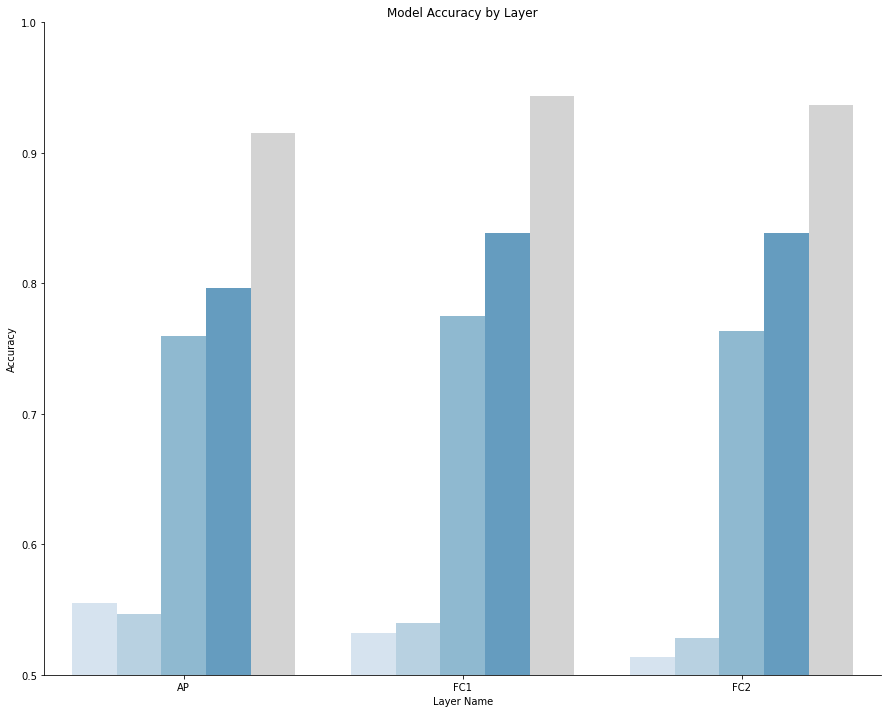

In [115]:
data = {
    'model_name': ['P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet',
                  'P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet',
                  'P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet'],
    
    'layer_name': ['AP', 'AP', 'AP', 'AP', 'AP',
                   'FC1','FC1','FC1','FC1','FC1',
                   'FC2','FC2','FC2','FC2','FC2'],
    
    'accuracy': [*bagnet_ap_mean_sal,
                *bagnet_fc1_mean_sal,
                *bagnet_fc2_mean_sal]
}

df = pd.DataFrame(data)

# Sample colors with RGB values
color_dict = {
    'P 11*11': (0.8229757785467128, 0.8898269896193771, 0.9527566320645905),
    'P 17*17': (0.6965013456362937, 0.8248366013071895, 0.9092656670511342),
    'P 31*31': (0.5168627450980392, 0.7357477893118032, 0.8601922337562476),
    'P 33*33': (0.3363783160322953, 0.6255132641291811, 0.8067358708189158),
    'Standard Alexnet':(0.827, 0.827, 0.827)
}

# Create bar plot
plt.figure(figsize=(15, 12))
sns.barplot(data=df, x='layer_name', y='accuracy', hue='model_name', palette=color_dict, ci=None)

# Adding titles and labels
plt.title('Model Accuracy by Layer')
plt.xlabel('Layer Name')
plt.ylabel('Accuracy')
plt.legend(title='Model Name').remove()


plt.ylim(0.5, 1.0) 


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig('./dev/manuscript_figures/pinholenet_contour_training_classifier_head.png', bbox_inches='tight', format='png', dpi=600)
# Display the plot
plt.show()

## Error bars work for 2

### Example to verify

In [118]:
# data = {
#     'model_name': ['P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet',
#                   'P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet'],
    
#     'layer_name': ['L1', 'L1', 'L1', 'L1', 'L1',
#                   'L2','L2','L2','L2','L2'],
    
#     'accuracy': [0.555,0.546,0.76,0.7967,0.915,
#                 0.513,0.528,0.7633,0.8383,0.9367],
    
#     'error': [0.01, 0.01, 0.03, 0.01, 0.01,  # your actual error values
#               0.03, 0.02, 0.01, 0.1, 0.02],
    
# }
# df = pd.DataFrame(data)

# # Sample colors with RGB values
# color_dict = {
#     'P 11*11': (0.8229757785467128, 0.8898269896193771, 0.9527566320645905),
#     'P 17*17': (0.6965013456362937, 0.8248366013071895, 0.9092656670511342),
#     'P 31*31': (0.5168627450980392, 0.7357477893118032, 0.8601922337562476),
#     'P 33*33': (0.3363783160322953, 0.6255132641291811, 0.8067358708189158),
#     'Standard Alexnet':(0.827, 0.827, 0.827)
# }

# plt.figure(figsize=(15, 12))
# barplot = sns.barplot(data=df, x='layer_name', y='accuracy', hue='model_name', palette=color_dict, ci=None)

# # Adjust the ylim to make sure error bars are visible
# plt.ylim(0.4, 1.0)

# # Since we have grouped data, we need to adjust the way we access the error values.
# # We'll use groupby and get_group to get the correct subsets.
# for name, group in df.groupby(['layer_name', 'model_name']):
#     layer_name, model_name = name
#     group_data = df[(df['layer_name'] == layer_name) & (df['model_name'] == model_name)]
    
#     # Get the positions of the bars for the current group
#     positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches if p.get_height() == group_data['accuracy'].values[0]]
    
#     # Plot the error bars for the current group
#     plt.errorbar(positions, group_data['accuracy'], yerr=group_data['error'], fmt='none', c='k', capsize=5)

# plt.title('Model Accuracy by Layer')
# plt.xlabel('Layer Name')
# plt.ylabel('Accuracy')

# # Remove the legend if not needed
# plt.legend(title='Model Name').remove()

# # Spine visibility settings as before
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

# plt.show()


#### **Pub**

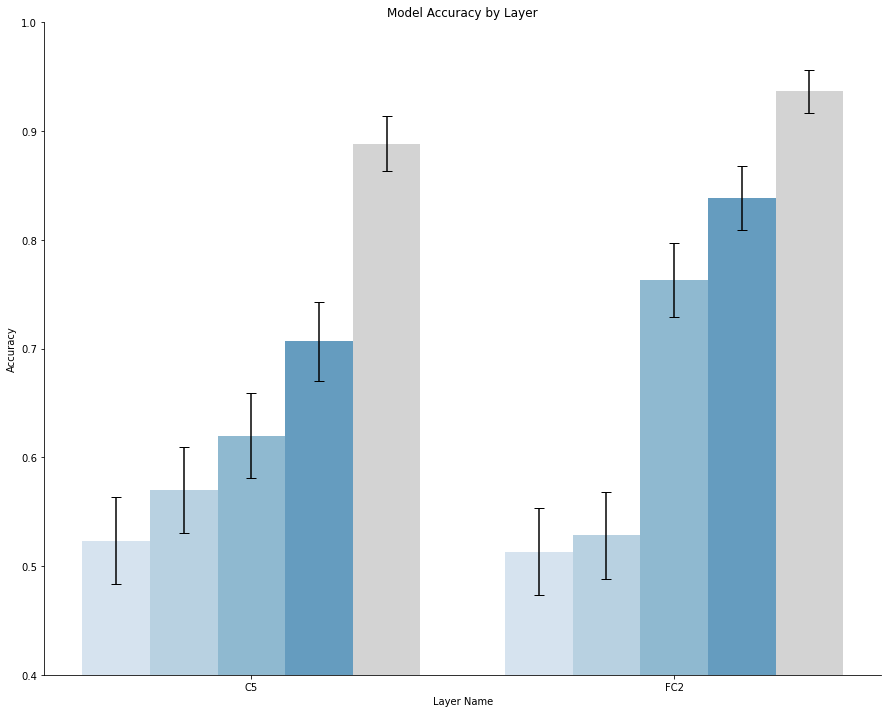

In [123]:
data = {
    'model_name': ['P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet',
                  'P 11*11', 'P 17*17', 'P 31*31', 'P 33*33','Standard Alexnet'],
    
    'layer_name': ['C5', 'C5', 'C5', 'C5', 'C5',
                   'FC2','FC2','FC2','FC2','FC2'],
    
    'accuracy': [*bagnet_conv5_mean_sal,
                *bagnet_fc2_mean_sal],
    
    'error': [*bagnet_conv5_confint_sal,
                *bagnet_fc2_confint_sal],
    
    
}

df = pd.DataFrame(data)

# Sample colors with RGB values
color_dict = {
    'P 11*11': (0.8229757785467128, 0.8898269896193771, 0.9527566320645905),
    'P 17*17': (0.6965013456362937, 0.8248366013071895, 0.9092656670511342),
    'P 31*31': (0.5168627450980392, 0.7357477893118032, 0.8601922337562476),
    'P 33*33': (0.3363783160322953, 0.6255132641291811, 0.8067358708189158),
    'Standard Alexnet':(0.827, 0.827, 0.827)
}

plt.figure(figsize=(15, 12))
barplot = sns.barplot(data=df, x='layer_name', y='accuracy', hue='model_name', palette=color_dict, ci=None)

# Adjust the ylim to make sure error bars are visible
plt.ylim(0.4, 1.0)

# Since we have grouped data, we need to adjust the way we access the error values.
# We'll use groupby and get_group to get the correct subsets.
for name, group in df.groupby(['layer_name', 'model_name']):
    layer_name, model_name = name
    group_data = df[(df['layer_name'] == layer_name) & (df['model_name'] == model_name)]
    
    # Get the positions of the bars for the current group
    positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches if p.get_height() == group_data['accuracy'].values[0]]
    
    # Plot the error bars for the current group
    plt.errorbar(positions, group_data['accuracy'], yerr=group_data['error'], fmt='none', c='k', capsize=5)

plt.title('Model Accuracy by Layer')
plt.xlabel('Layer Name')
plt.ylabel('Accuracy')

# Remove the legend if not needed
plt.legend(title='Model Name').remove()

# Spine visibility settings as before
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig('./dev/manuscript_figures/f3_bagnet_comparison.png', format='png', dpi=600)
plt.show()

# 10) Analyse other images [Gaboriforms]

In [ ]:
def get_output(files,all_images):
    all_models_output={}


    for f in tqdm(files):
        checkpoint=torch.load(f)
        loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
        loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
        output=loaded_spliced_model.forward(all_images).detach().cpu().numpy()
        all_models_output[checkpoint['training_config']['layer_name']]=output



    myKeys = list(all_models_output.keys())
    myKeys.sort()
    all_models_output = {i: all_models_output[i] for i in myKeys}
    
    return all_models_output

In [ ]:
def get_list_output(acc_dict,list_layers):
    acc=[]
    for i in range(len(list_layers)):
        # layer=list_layers[i].replace('_','.')
        layer=list_layers[i]
        if layer in acc_dict.keys():
            acc.append(acc_dict[layer])
            
    return acc


### Single image

In [ ]:
# normalize images using parameters from the training image set
just_vis_transform= transforms.Compose([       
 transforms.Resize(256),transforms.Pad(128),
 transforms.CenterCrop((512,512)),transforms.ToTensor()])

In [ ]:
img=Image.open('dev/random_images/gaboriforms/sketch_N10_A_helvetica.png').convert('RGB')
# img=Image.open('dev/random_images/gaboriforms/sketch_P10_A_helvetica.png').convert('RGB')
# img=Image.open('dev/random_images/gaboriforms/sketch_P30_A_helvetica.png').convert('RGB')



plt.imshow(np.array(img))
plt.show()

plt.imshow(np.transpose(just_vis_transform(img).numpy(),(1,2,0)))

In [ ]:
# normalize images using parameters from the training image set
gaboriform_transform= transforms.Compose([       
 transforms.Resize(256),transforms.Pad(128),
 transforms.CenterCrop((512,512)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225])])

In [ ]:
# img=Image.open('./dev/random_images/gaboriforms/sketch_Random_A_helvetica.png').convert('RGB')
img=Image.open('dev/random_images/gaboriforms/sketch_P30_A_helvetica.png').convert('RGB')
img=gaboriform_transform(img)
img=img.to(device)
img=torch.unsqueeze(img,0)
img.shape

In [ ]:
output=loaded_spliced_model.forward(img).detach().cpu()
output.shape

### All images and all layers

In [ ]:
n10_img=Image.open('dev/random_images/gaboriforms/sketch_N10_A_helvetica.png').convert('RGB')
n10_img=gaboriform_transform(n10_img).to(device)
n10_img=torch.unsqueeze(n10_img,0)

p10_img=Image.open('dev/random_images/gaboriforms/sketch_P10_A_helvetica.png').convert('RGB')
p10_img=gaboriform_transform(p10_img).to(device)
p10_img=torch.unsqueeze(p10_img,0)

p30_img=Image.open('dev/random_images/gaboriforms/sketch_P30_A_helvetica.png').convert('RGB')
p30_img=gaboriform_transform(p30_img).to(device)
p30_img=torch.unsqueeze(p30_img,0)



In [ ]:
all_images=torch.cat((n10_img,p10_img,p30_img),0)

In [ ]:
list_layers=['features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

for i in range(len(list_layers)):
    list_layers[i]=list_layers[i].replace('_','.')

In [ ]:
sup_regular_finetune_files = glob.glob("../../dev/model_hub/regular_alexnet/model_sup-regular_*finetune.pt")

In [ ]:
all_models_output=get_list_acc(get_output(sup_regular_finetune_files,all_images),list_layers)

all_models_output=np.array(all_models_output)

In [ ]:
all_models_output.shape

In [ ]:
print(np.linalg.norm(all_models_output[0][0] - all_models_output[0][1]))
print(np.linalg.norm(all_models_output[0][1] - all_models_output[0][2]))

In [ ]:
list_distances=[]
for i in range(all_models_output.shape[0]):
    d1=np.linalg.norm(all_models_output[i][0] - all_models_output[i][1])
    d2=np.linalg.norm(all_models_output[i][1] - all_models_output[i][2])
    list_distances.append([d1,d2])
list_distances=np.array(list_distances)

In [ ]:
list_corr=[]
for i in range(all_models_output.shape[0]):
    r1=np.corrcoef(all_models_output[i][0],all_models_output[i][1])[0][1]
    r2=np.corrcoef(all_models_output[i][1],all_models_output[i][2])[0][1]
    list_corr.append([r1,r2])
list_corr=np.array(list_corr)

In [ ]:
# print(all_models_output[3])
# print(np.corrcoef(all_models_output[3][0],all_models_output[3][2]))
# plt.plot(all_models_output[3][0],all_models_output[3][2])
# print(all_models_output[3][0],all_models_output[3][2])

#### list distances=for each layer globally similiar and dissimiliar

In [ ]:
plt.plot(np.arange(len(list_distances[:,0])),list_distances[:,0])
plt.plot(np.arange(len(list_distances[:,1])),list_distances[:,1])

In [ ]:
plt.plot(np.arange(len(list_corr[:,0])),list_corr[:,0])
plt.plot(np.arange(len(list_corr[:,1])),list_corr[:,1])

# All images -> all layers of single ,model

In [ ]:
n10_img=Image.open('dev/random_images/gaboriforms/sketch_N10_A_helvetica.png').convert('RGB')
n10_img=gaboriform_transform(n10_img).to(device)
n10_img=torch.unsqueeze(n10_img,0)

p10_img=Image.open('dev/random_images/gaboriforms/sketch_P10_A_helvetica.png').convert('RGB')
p10_img=gaboriform_transform(p10_img).to(device)
p10_img=torch.unsqueeze(p10_img,0)

p30_img=Image.open('dev/random_images/gaboriforms/sketch_P30_A_helvetica.png').convert('RGB')
p30_img=gaboriform_transform(p30_img).to(device)
p30_img=torch.unsqueeze(p30_img,0)


random_img=Image.open('dev/random_images/gaboriforms/sketch_Random_A_helvetica.png').convert('RGB')
random_img=gaboriform_transform(random_img).to(device)
random_img=torch.unsqueeze(random_img,0)



In [ ]:
all_images=torch.cat((n10_img,p10_img,p30_img,random_img),0)
all_images.shape

In [ ]:
# checkpoint=torch.load('../../dev/model_hub/regular_alexnet/model_sup-regular_layer_avgpool_mode_frozen.pt')
# checkpoint=torch.load('../../dev/model_hub/stylized_alexnet/model_sup-stylized_layer_avgpool_mode_frozen.pt')


# checkpoint=torch.load('../../dev/model_hub/regular_alexnet/model_sup-regular_layer_avgpool_mode_finetune.pt')
checkpoint=torch.load('../../dev/model_hub/constrained_finetuning/alexnet/B_018/model_sup-regular_layer_avgpool_mode_finetune.pt')

In [ ]:
loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)

loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)

In [ ]:
loaded_spliced_model

In [ ]:
# for name,module in loaded_spliced_model.base_model.named_modules():
#     print(name)

In [ ]:
list_layers=['features.0','features.1','features.2','features.3','features.4','features.5','features.6','features.7','features.8','features.9','features.10','features.11','features.12','avgpool']
for i in range(len(list_layers)):
    list_layers[i]='base_model.'+list_layers[i]

In [ ]:
list_distances=[]
list_corr=[]

for layer_name in list_layers:

    output=None
    with FeatureExtractor(loaded_spliced_model, layer_name) as extractor:

        features = extractor(all_images)
        temp_output=features[layer_name]
        if(len(temp_output.shape)!=2):
            temp_output=temp_output.view((temp_output.shape[0],-1))
        output=temp_output.numpy()
        
        
        d1=np.linalg.norm(output[0] - output[1])
        d2=np.linalg.norm(output[1] - output[2])
        d3_random=np.linalg.norm(output[1] - output[3])
        list_distances.append([d1,d2,d3_random])
        
        
        r1=np.corrcoef(output[0],output[1])[0][1]
        r2=np.corrcoef(output[1],output[2])[0][1]
        r3_random=np.corrcoef(output[1],output[3])[0][1]
        list_corr.append([r1,r2,r3_random])

    print(output.shape)
list_distances=np.array(list_distances)
list_corr=np.array(list_corr)

In [ ]:
plt.plot(np.arange(len(list_distances[:,0])),list_distances[:,0],label='globally similiar')
plt.plot(np.arange(len(list_distances[:,1])),list_distances[:,1],label='globally dissimiliar')
plt.plot(np.arange(len(list_distances[:,2])),list_distances[:,2],label='random')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [ ]:
plt.plot(np.arange(len(list_corr[:,0])),list_corr[:,0],label='globally similiar')
plt.plot(np.arange(len(list_corr[:,1])),list_corr[:,1],label='globally dissimiliar')
plt.plot(np.arange(len(list_corr[:,2])),list_corr[:,2],label='random')
plt.ylim(0.0,1.1)
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## Comparing Alexnet 0R, Stylized Alexnet OR, CI-Broad, CI-Narrow

In [ ]:
# alexnet_or=copy.deepcopy(list_corr)

# alexnet_stylized=copy.deepcopy(list_corr)


# alexnet_cibroad=copy.deepcopy(list_corr)


# alexnet_cinarrow=copy.deepcopy(list_corr)

In [ ]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.plot(np.arange(len(alexnet_or[:,0])),alexnet_or[:,0],label='globally similiar')
plt.plot(np.arange(len(alexnet_or[:,1])),alexnet_or[:,1],label='globally dissimiliar')
plt.plot(np.arange(len(alexnet_or[:,2])),alexnet_or[:,2],label='random')
plt.ylim(0.0,1.1)
plt.legend()
plt.title('Alexnet OR')
plt.xlabel('Model Layer')
plt.ylabel('Correlation')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)




plt.subplot(2,2,2)
plt.plot(np.arange(len(alexnet_stylized[:,0])),alexnet_stylized[:,0],label='globally similiar')
plt.plot(np.arange(len(alexnet_stylized[:,1])),alexnet_stylized[:,1],label='globally dissimiliar')
plt.plot(np.arange(len(alexnet_stylized[:,2])),alexnet_stylized[:,2],label='random')
plt.ylim(0.0,1.1)
plt.legend()
plt.title('Alexnet Stylized')
plt.xlabel('Model Layer')
plt.ylabel('Correlation')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)




plt.subplot(2,2,3)
plt.plot(np.arange(len(alexnet_cibroad[:,0])),alexnet_cibroad[:,0],label='globally similiar')
plt.plot(np.arange(len(alexnet_cibroad[:,1])),alexnet_cibroad[:,1],label='globally dissimiliar')
plt.plot(np.arange(len(alexnet_cibroad[:,2])),alexnet_cibroad[:,2],label='random')
plt.ylim(0.0,1.1)
plt.legend()
plt.title('Alexnet CI Broad')
plt.xlabel('Model Layer')
plt.ylabel('Correlation')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)




plt.subplot(2,2,4)
plt.plot(np.arange(len(alexnet_cinarrow[:,0])),alexnet_cinarrow[:,0],label='globally similiar')
plt.plot(np.arange(len(alexnet_cinarrow[:,1])),alexnet_cinarrow[:,1],label='globally dissimiliar')
plt.plot(np.arange(len(alexnet_cinarrow[:,2])),alexnet_cinarrow[:,2],label='random')
plt.ylim(0.0,1.1)
plt.legend()
plt.title('Alexnet CI Narrow')
plt.xlabel('Model Layer')
plt.ylabel('Correlation')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)




In [ ]:
alexnet_or_diff=np.abs(alexnet_or[:,0] - alexnet_or[:,1])
alexnet_stylized_diff=np.abs(alexnet_stylized[:,0] - alexnet_stylized[:,1])
alexnet_cibroad_diff=np.abs(alexnet_cibroad[:,0] - alexnet_cibroad[:,1])
alexnet_cinarrow_diff=np.abs(alexnet_cinarrow[:,0] - alexnet_cinarrow[:,1])

In [ ]:
# plt.figure(figsize=(10,6))
# plt.plot(np.arange(len(alexnet_or_diff)),alexnet_or_diff,label='Alexnet OR')
# plt.plot(np.arange(len(alexnet_stylized_diff)),alexnet_stylized_diff,label='Alexnet Stylized')
# plt.plot(np.arange(len(alexnet_cibroad_diff)),alexnet_cibroad_diff,label='Alexnet CI Broad')
# plt.plot(np.arange(len(alexnet_cinarrow_diff)),alexnet_cinarrow_diff,label='Alexnet CI Narrow')
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.legend()
# plt.show()


In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(np.arange(len(alexnet_or_diff)),alexnet_or_diff,label='Alexnet OR')
plt.ylim(0.0,0.07)
plt.title('Alexnet OR')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)




plt.subplot(2,2,2)
plt.plot(np.arange(len(alexnet_stylized_diff)),alexnet_stylized_diff,label='Alexnet Stylized')
plt.ylim(0.0,0.07)
plt.title('Alexnet Stylized')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)




plt.subplot(2,2,3)
plt.plot(np.arange(len(alexnet_cibroad_diff)),alexnet_cibroad_diff,label='Alexnet CI Broad')
plt.ylim(0.0,0.07)
plt.title('Alexnet CI Broad')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)




plt.subplot(2,2,4)
plt.plot(np.arange(len(alexnet_cinarrow_diff)),alexnet_cinarrow_diff,label='Alexnet CI Narrow')
plt.ylim(0.0,0.07)
plt.title('Alexnet CI Narrow')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)




# Previous analysis - OMIT

# Supervised regular vs stylized

In [ ]:
sup_regular_frozen_files = glob.glob("../../dev/updated_finetuned_models/model_sup-regular_*frozen.pt")
sup_regular_finetune_files = glob.glob("../../dev/updated_finetuned_models/model_sup-regular_*finetune.pt")

sup_stylized_frozen_files = glob.glob("../../dev/updated_finetuned_models/model_sup-stylized_*frozen.pt")
sup_stylized_finetune_files = glob.glob("../../dev/updated_finetuned_models/model_sup-stylized_*finetune.pt")



In [ ]:
sup_regular_frozen_acc={'train':get_train_val_acc(sup_regular_frozen_files)[0],'val':get_train_val_acc(sup_regular_frozen_files)[1]}

sup_regular_finetune_acc={'train':get_train_val_acc(sup_regular_finetune_files)[0],'val':get_train_val_acc(sup_regular_finetune_files)[1]}

sup_stylized_frozen_acc={'train':get_train_val_acc(sup_stylized_frozen_files)[0],'val':get_train_val_acc(sup_stylized_frozen_files)[1]}

sup_stylized_finetune_acc={'train':get_train_val_acc(sup_stylized_finetune_files)[0],'val':get_train_val_acc(sup_stylized_finetune_files)[1]}

In [ ]:
sup_stylized_frozen_acc['val']

In [ ]:
plt.figure(figsize=(12,10))



plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),'.',markersize=7,color='r',label='supervised regular frozen')
plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),alpha=0.4,color='r')

plt.plot(np.arange(len(get_list_acc(sup_stylized_frozen_acc['val'],list_layers))),get_list_acc(sup_stylized_frozen_acc['val'],list_layers),'.',markersize=7,color='g',label='supervised stylized frozen')
plt.plot(np.arange(len(get_list_acc(sup_stylized_frozen_acc['val'],list_layers))),get_list_acc(sup_stylized_frozen_acc['val'],list_layers),alpha=0.4,color='g')


for i in range(len(get_list_acc(sup_stylized_frozen_acc['val'],list_layers))):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_stylized_frozen_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.5,1.0)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.title('After 100 epochs of training')
plt.show()



In [ ]:
plt.figure(figsize=(12,10))



plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),'.',markersize=7,color='r',label='supervised regular finetune')
plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),alpha=0.4,color='r')

plt.plot(np.arange(len(get_list_acc(sup_stylized_finetune_acc['val'],list_layers))),get_list_acc(sup_stylized_finetune_acc['val'],list_layers),'.',markersize=7,color='g',label='supervised stylized finetune')
plt.plot(np.arange(len(get_list_acc(sup_stylized_finetune_acc['val'],list_layers))),get_list_acc(sup_stylized_finetune_acc['val'],list_layers),alpha=0.4,color='g')



for i in range(len(get_list_acc(sup_stylized_finetune_acc['val'],list_layers))):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_stylized_finetune_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.5,1.0)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.title('After 100 epochs of training')
plt.show()
    
    

In [ ]:
plt.figure(figsize=(12,10))




plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),'.',markersize=7,color='r',label='frozen')
plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),alpha=0.4,color='r')

plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),'.',markersize=7,color='g',label='finetune')
plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),alpha=0.4,color='g')





for i in range(len(get_list_acc(sup_stylized_finetune_acc['val'],list_layers))):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_stylized_finetune_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(0.5,1.0)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.title('After 100 epochs of training')
plt.show()
    
    

# Same plots as above but with training accuracy

In [ ]:
plt.figure(figsize=(12,10))



plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),'.',markersize=7,color='r',label='supervised regular frozen - Val')
plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),alpha=0.4,color='r')
plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['train'],list_layers))),get_list_acc(sup_regular_frozen_acc['train'],list_layers),'*',color='r',label='supervised regular frozen - Train')

plt.plot(np.arange(len(get_list_acc(sup_stylized_frozen_acc['val'],list_layers))),get_list_acc(sup_stylized_frozen_acc['val'],list_layers),'.',markersize=7,color='g',label='supervised stylized frozen- Val')
plt.plot(np.arange(len(get_list_acc(sup_stylized_frozen_acc['val'],list_layers))),get_list_acc(sup_stylized_frozen_acc['val'],list_layers),alpha=0.4,color='g')
plt.plot(np.arange(len(get_list_acc(sup_stylized_frozen_acc['train'],list_layers))),get_list_acc(sup_stylized_frozen_acc['train'],list_layers),'*',color='g',label='supervised stylized frozen - Train')


for i in range(len(get_list_acc(sup_stylized_frozen_acc['val'],list_layers))):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_stylized_frozen_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylabel('Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.title('After 100 epochs of training')
plt.show()




In [ ]:
plt.figure(figsize=(12,10))



plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),'.',markersize=7,color='r',label='supervised regular finetune - Val')
plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),alpha=0.4,color='r')
plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['train'],list_layers))),get_list_acc(sup_regular_finetune_acc['train'],list_layers),'*',color='r',label='supervised regular finetune - Train')

plt.plot(np.arange(len(get_list_acc(sup_stylized_finetune_acc['val'],list_layers))),get_list_acc(sup_stylized_finetune_acc['val'],list_layers),'.',markersize=7,color='g',label='supervised stylized finetune - Val')
plt.plot(np.arange(len(get_list_acc(sup_stylized_finetune_acc['val'],list_layers))),get_list_acc(sup_stylized_finetune_acc['val'],list_layers),alpha=0.4,color='g')
plt.plot(np.arange(len(get_list_acc(sup_stylized_finetune_acc['train'],list_layers))),get_list_acc(sup_stylized_finetune_acc['train'],list_layers),'*',color='g',label='supervised stylized finetune - Train')



for i in range(len(get_list_acc(sup_stylized_finetune_acc['val'],list_layers))):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(len(get_list_acc(sup_stylized_finetune_acc['val'],list_layers))),list_layers,rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylabel('Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.title('After 100 epochs of training')
plt.show()
    
    

# Convergence

In [ ]:
def get_train_val_data(files):
    all_models_train_acc={}
    all_models_val_acc={}
    
    all_models_train_loss={}
    all_models_val_loss={}

    for f in files:
        checkpoint=torch.load(f)
        
        all_models_train_acc[checkpoint['training_config']['layer_name']]=checkpoint['metrics']['train_acc']
        all_models_val_acc[checkpoint['training_config']['layer_name']]=checkpoint['metrics']['val_acc']
        
        all_models_train_loss[checkpoint['training_config']['layer_name']]=checkpoint['metrics']['train_loss']
        all_models_val_loss[checkpoint['training_config']['layer_name']]=checkpoint['metrics']['val_loss']
    
    
    return all_models_train_acc,all_models_val_acc, all_models_train_loss, all_models_val_loss

In [ ]:
def plot_train_val_data(data_dict,type_data='acc'):
    plt.figure(figsize=(25,15))
    for i in range(len(list_layers)):


        plt.subplot(3,7,i+1)
        plt.plot(np.arange(len(data_dict['train_'+type_data][list_layers[i]])),data_dict['train_'+type_data][list_layers[i]],label='train')
        plt.plot(np.arange(len(data_dict['val_'+type_data][list_layers[i]])),data_dict['val_'+type_data][list_layers[i]],label='val')
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.title(list_layers[i])
        
        plt.xlabel('Epochs')
        if(type_data=='acc'):
            plt.ylim(0.4,1.0)
    plt.legend()
    plt.show()



In [ ]:
sup_regular_frozen_files = glob.glob("../../dev/updated_finetuned_models/model_sup-regular_*frozen.pt")
sup_regular_finetune_files = glob.glob("../../dev/updated_finetuned_models/model_sup-regular_*finetune.pt")

sup_stylized_frozen_files = glob.glob("../../dev/updated_finetuned_models/model_sup-stylized_*frozen.pt")
sup_stylized_finetune_files = glob.glob("../../dev/updated_finetuned_models/model_sup-stylized_*finetune.pt")



In [ ]:
sup_regular_frozen_data={'train_acc':get_train_val_data(sup_regular_frozen_files)[0],'val_acc':get_train_val_data(sup_regular_frozen_files)[1], 'train_loss':get_train_val_data(sup_regular_frozen_files)[2], 'val_loss':get_train_val_data(sup_regular_frozen_files)[3]}

sup_regular_finetune_data={'train_acc':get_train_val_data(sup_regular_finetune_files)[0],'val_acc':get_train_val_data(sup_regular_finetune_files)[1], 'train_loss':get_train_val_data(sup_regular_finetune_files)[2], 'val_loss':get_train_val_data(sup_regular_finetune_files)[3]}

sup_stylized_frozen_data={'train_acc':get_train_val_data(sup_stylized_frozen_files)[0],'val_acc':get_train_val_data(sup_stylized_frozen_files)[1], 'train_loss':get_train_val_data(sup_stylized_frozen_files)[2], 'val_loss':get_train_val_data(sup_stylized_frozen_files)[3]}

sup_stylized_finetune_data={'train_acc':get_train_val_data(sup_stylized_finetune_files)[0],'val_acc':get_train_val_data(sup_stylized_finetune_files)[1], 'train_loss':get_train_val_data(sup_stylized_finetune_files)[2], 'val_loss':get_train_val_data(sup_stylized_finetune_files)[3]}

### Acc

In [ ]:
print('Accuracy Plots')
plot_train_val_data(sup_regular_finetune_data,type_data='acc')

print('\n\n\n\n')

print('Loss Plots')
plot_train_val_data(sup_regular_finetune_data,type_data='loss')